In [1]:
import numpy as np
from copy import copy
import numpy as np
from random import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from multiprocessing import Pool
from StabCircuits import *
from ChainCodes import *

In [2]:
class ChainCodes:
    def __init__(self, args):
        self.T1 = args['T1']
        self.Tf = args['Tf']
        self.Tg1Q = args['Tg1Q']
        self.Tg2Q = args['Tg2Q']
        self.tm = args['tm']
        self.td = args['td']
        self.eta = args['eta']
        # self.p_axis = args['p_axis']
        # self.p_plane = args['p_plane']
        
        
    
    
    def damping(self, table, q, t):
        if random() < 1-np.exp(-t/self.T1/2):
            table = X_gate(table, q)
        if random() < 1-np.exp(-t/self.T1/2):
            table = Y_gate(table, q)
        if random() < 1-np.exp(-t/self.Tf):
            table = Z_gate(table, q)
        return table
    



    def cycle(self, table, n, basis):
        # basis = '0', '1, '+', '-', 'i+', 'i-'
        if (n - 10)%8 != 0:
            print("Wrong n!!!")
        m_data = np.zeros((n//2), dtype=np.int8)
        m_ancilla = np.zeros((n//2), dtype=np.int8)
        m_data_ideal = np.zeros((n//2), dtype=np.int8)
        m_ancilla_ideal = np.zeros((n//2), dtype=np.int8)
        
        even = np.arange(n//2)*2 # ancilla qubits
        odd = np.arange(n//2)*2 + 1 # data qubits
        
        # correction cycle
        for i in even:
            table = self.damping(table, i, self.Tg1Q/2)
            table = Hadamard(table, i)
        for i in even:
            table = self.damping(table, i, self.Tg1Q/2 + self.Tg2Q/2)
            table = self.damping(table, i+1, self.Tg1Q + self.Tg2Q/2)
            table = iSWAP(table, i, i+1)
        for i in even:
            table = self.damping(table, i, self.Tg1Q/2 + self.Tg2Q/2)
            table = Phase(table, i)
            table = Hadamard(table, i)
        for i in odd:
            table = self.damping(table, i, self.Tg1Q + self.Tg2Q)
            table = self.damping(table, i+1, self.Tg1Q/2 + self.Tg2Q/2)
            table = iSWAP(table, i, (i+1)%n)
        for i in even:
            table = self.damping(table, i, self.Tg2Q)
            table = self.damping(table, i+1, self.Tg2Q)
            table = iSWAP(table, i, i+1)
        for i in even:
            table = self.damping(table, i, self.Tg1Q/2 + self.Tg2Q/2)
            table = Z_gate(table, i)
            table = Hadamard(table, i)
        for i in odd:
            table = self.damping(table, i, self.Tg1Q + self.Tg2Q)
            table = self.damping(table, i+1, self.Tg1Q/2 + self.Tg2Q/2)
            table = iSWAP(table, i, (i+1)%n)
        for i in even:
            table = self.damping(table, i, self.Tg2Q/2 + self.Tg1Q/2)
            table = self.damping(table, i+1, self.Tg2Q/2)
            table = Hadamard(table, i)
            table = Phase(table, i+1)
            table = self.damping(table, i, self.Tg1Q/2)
            table = self.damping(table, i+1, self.Tg1Q)

            

        # ancilla measurement
        for i in even:
            table, m_ancilla[i//2] = measure(table, i, self.eta)
            table, m = measure(table, i)
            if m == -1:
                table = X_gate(table, i)
        
        # data measurement
        table_tmp = copy(table)
        table_tmp_ideal = copy(table)
        for i in odd:
            if basis == '+' or basis == '-':
                table_tmp = Ry_05_gate(table_tmp, i)
                table_tmp_ideal = Ry_05_gate(table_tmp_ideal, i)
            elif basis == 'i+' or basis == 'i-':
                table_tmp = Rx05_gate(table_tmp, i)
                table_tmp_ideal = Rx05_gate(table_tmp_ideal, i)

            table_tmp, m_data[(i-1)//2] = measure(table_tmp, i, self.eta)
            table_tmp_ideal, m_data_ideal[(i-1)//2] = measure(table_tmp_ideal, i)
        
        for i in odd:
            table = self.damping(table, i, self.tm+self.td)
            
            
        return table, m_data_ideal.astype(np.int8), m_data.astype(np.int8), m_ancilla.astype(np.int8)




    def set_full_Cycle(self, table, N, N_cycle, basis):
        self.table = table
        self.N = N
        self.N_cycle = N_cycle
        self.basis = basis




    def full_Cycle(self, proc_num):
        M_data_ideal = np.zeros((self.N_cycle, self.N//2), dtype = np.int8)
        M_data = np.zeros((self.N_cycle, self.N//2), dtype = np.int8)
        M_ancilla = np.zeros((self.N_cycle, self.N//2), dtype = np.int8)
        for n_cycle in range(0, self.N_cycle):
            table, M_data_ideal[n_cycle],\
                   M_data[n_cycle], M_ancilla[n_cycle] = self.cycle(self.table, self.N, self.basis)
        return [M_data_ideal, M_data, M_ancilla]

In [4]:
T1 = 30 # Qubit relaxation time
Tf = 60 # Qubit dephasing time
Tg1Q = 0.02 # Single-qubit gate time
Tg2Q = 0.04 # Two-qubit gate time
tm = 0.3 # Measurement time
td = 0.3 # Depletion time



# p_axis = 10**(-4) # In-axis rotation error
# p_plane = 5 * 10**(-4) # In-plane rotation error 

# dphi = 0.01

# eta_origin = np.array([[0.9985, 0, 0.0015, 0],
#                        [0.005, 0.0015, 0.0149, 0.9788]])

eta_origin = np.array([[1, 0, 0., 0],
                       [0., 0., 0., 1]])

eta = np.zeros((2, 3))
for i in range(0, 3):
    eta[:, i] = np.sum(eta_origin[:, :i+1], axis = 1)
print(eta)



Tg1Q = 0.0 # Single-qubit gate time
Tg2Q = 0.0 # Two-qubit gate time
tm = 0 # Measurement time
td = 0 # Depletion time

# p_axis = 0
# p_plane = 0

arg = {
    'T1':        T1,
    'Tf':        Tf,
    'Tg1Q':      Tg1Q,
    'Tg2Q':      Tg2Q,
    'tm':        tm,
    'td':        td,
    'eta':       eta
}

CC = ChainCodes(arg)


no_decoding_ideal_meas = [0.9878, 0.9194, 0.8578, 0.807, 0.7572, 0.7274, 0.696,  0.6756, 0.6546, 0.6364,
                          0.6044, 0.5878, 0.5782, 0.5646, 0.554,  0.5468, 0.5312, 0.522, 0.5268, 0.5198]
no_decoding_19000 = [0.94086842, 0.86075263, 0.79460526, 0.74111053, 0.69727368, 0.66065263,
 0.63175789, 0.60793684, 0.59002632, 0.57212105, 0.55781053, 0.54898947,
 0.53999474, 0.53286842, 0.52607368, 0.52111053, 0.51917368, 0.51610526,
 0.51216316, 0.51022105]

[[1. 1. 1.]
 [0. 0. 0.]]


In [5]:
MultiProcessing = True
N_process = 8
N = 10
fout = '_stab_instate'
N_run = 1
N_cycle = 20
M_datanomeas = np.zeros((N_run, N_cycle, N//2), dtype = np.int8)
M_ancillanomeas = np.zeros((N_run, N_cycle, N//2), dtype = np.int8)
basis = '0'
table = init_state0(N)
odd = np.arange(N//2)*2 + 1
Meas = []


if basis == '1':
    for i in odd:
        table = X_gate(table, i)
elif basis == '+':
    for i in odd:
        table = Ry05_gate(table, i)
elif basis == '-':
    for i in odd:
        table = Ry_05_gate(table, i)
elif basis == 'i+':
    for i in odd:
        table = Rx_05_gate(table, i)
elif basis == 'i-':
    for i in odd:
        table = Rx05_gate(table, i)

CC.set_full_Cycle(table, N, N_cycle, basis)
if MultiProcessing:
    with Pool(N_process) as p:
        Meas = list(tqdm(p.imap(CC.full_Cycle, range(N_run)), total=N_run))
else:
    Meas = list(tqdm(map(CC.full_Cycle, range(N_run)), total=N_run))

M_data_ideal = np.asarray(Meas, dtype=np.int8)[:,0]
M_data = np.asarray(Meas, dtype=np.int8)[:,1]
M_ancilla = np.asarray(Meas, dtype=np.int8)[:,2]


for i in tqdm(range(N_run)):
    for j in range(N_cycle):
        M_data_ideal[i, j] = np.roll(M_data_ideal[i, j], -2*j)
        M_ancilla[i, j] = np.roll(M_ancilla[i, j], 2*j)
        M_data[i, j] = np.roll(M_data[i, j], -2*j)

        
# np.savez_compressed('N' + str(N) + fout + basis + '_' + str(N_run), M_data = M_data, M_ancilla = M_ancilla,\
#                            M_datanomeas = M_datanomeas, M_ancillanomeas = M_ancillanomeas)

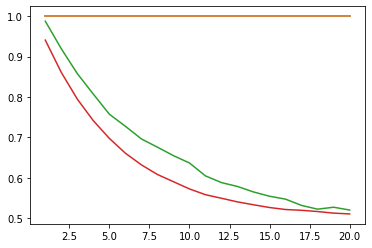

In [6]:
def no_decoding(M_data):
    return (np.mean(np.prod(M_data, axis=2), axis=0)+1)/2
            
plt.plot(np.linspace(1, 20, 20), no_decoding(M_data))
plt.plot(np.linspace(1, 20, 20), no_decoding(M_data_ideal))

plt.plot(np.linspace(1, 20, 20), no_decoding_ideal_meas, label='onlyT1, dens')
plt.plot(np.linspace(1, 20, 20), no_decoding_19000, label='onlyT1, dens')

In [38]:
print(np.prod(M_data_ideal, axis=2))
print(np.prod(M_data, axis=2))
print(M_ancilla)

[[ 1  1  1  1 -1  1  1 -1 -1 -1  1  1  1  1  1  1  1 -1 -1  1]]
[[ 1  1  1  1 -1  1  1 -1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1]]
[[[-1  1  1 -1  1]
  [-1  1  1 -1  1]
  [-1  1  1 -1  1]
  [-1  1  1 -1  1]
  [-1 -1  1  1  1]
  [ 1  1 -1  1  1]
  [ 1  1 -1 -1  1]
  [-1 -1  1  1  1]
  [-1 -1  1  1  1]
  [-1 -1  1  1  1]
  [-1  1  1  1 -1]
  [-1  1  1  1 -1]
  [ 1  1  1 -1  1]
  [-1  1 -1 -1 -1]
  [-1  1 -1 -1 -1]
  [-1  1 -1  1 -1]
  [-1  1 -1 -1 -1]
  [-1  1  1 -1 -1]
  [-1  1  1 -1  1]
  [ 1 -1 -1 -1  1]]]
